# Validating fine-tuned Generator via behavioural real-world data 
- using Wahlomat survey to compare generated results versus real-world party answers from the 2025 Bundestagswahl

In [113]:
# Setup -load packages
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    balanced_accuracy_score
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from matplotlib.colors import LinearSegmentedColormap
import re

# load data 
wahlomat_data = pd.read_csv("../data/Wahl-O-Mat_results_sys_adapted.csv")
# renaming Union into CDU/CSU
wahlomat_data['party'].replace('Union','CDU/CSU',inplace=True)
wahlomat_data['party'].value_counts()


/var/folders/jp/7rxct1gj4xsc_51ldxz05w9w0000gn/T/ipykernel_7369/3978299925.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  wahlomat_data['party'].replace('Union','CDU/CSU',inplace=True)


party
SPD        38
CDU/CSU    38
GRÜNE      38
FDP        38
AfD        38
LINKE      38
Name: count, dtype: int64

_________________________________________________________________
Extracting answers from generated responses
__________________________________________________________________

In [115]:
# editing the answers in new column: all to lower case, removing all punctuation
wahlomat_data["model_answer_01_edit"] = wahlomat_data["model_answer_01"].str.lower().str.translate(str.maketrans('', '', string.punctuation))
wahlomat_data["model_answer_03_edit"] = wahlomat_data["model_answer_03"].str.lower().str.translate(str.maketrans('', '', string.punctuation))


In [116]:
wahlomat_data

,party,question,answer,model_answer_01,model_answer_03,model_answer_01_edit,model_answer_03_edit
0,SPD,Deutschland soll die Ukraine weiterhin militär...,stimme zu,#Neutral# Es gibt viele Argumente für eine wei...,#StimmtZuhause! Ich stimme für das Vorgehen De...,neutral es gibt viele argumente für eine weite...,stimmtzuhause ich stimme für das vorgehen deut...
1,CDU/CSU,Deutschland soll die Ukraine weiterhin militär...,stimme zu,#Streitfall# Du hast einen Fehler gemacht! Bit...,#Neutral# 😐 Ich bin kein Politiker oder Partei...,streitfall du hast einen fehler gemacht bitte ...,neutral 😐 ich bin kein politiker oder parteifu...
2,GRÜNE,Deutschland soll die Ukraine weiterhin militär...,stimme zu,"#StimmtZU! Ich stimme dem Satz ""Deutschland so...","#StimmtZU! Ich stimme dem Satz ""Deutschland so...",stimmtzu ich stimme dem satz deutschland sollt...,stimmtzu ich stimme dem satz deutschland sollt...
3,FDP,Deutschland soll die Ukraine weiterhin militär...,stimme zu,#Neutral# Du hast keine Auswahlmöglichkeiten f...,#Neutral# Ja oder Nein wäre für eine Parteipol...,neutral du hast keine auswahlmöglichkeiten für...,neutral ja oder nein wäre für eine parteipolit...
4,AfD,Deutschland soll die Ukraine weiterhin militär...,stimme nicht zu,#Stelle eine Aussprache an! Es gibt wichtige P...,#Neutral# Ich bin kein Politiker; ich kann kei...,stelle eine aussprache an es gibt wichtige pun...,neutral ich bin kein politiker ich kann keine ...
...,...,...,...,...,...,...,...
223,CDU/CSU,Der gesetzliche Mindestlohn soll spätestens 20...,neutral,#Neutral# Ich bin kein Mitglied dieser Fraktio...,#Neutral# Ich bin kein Mitglied dieser Fraktio...,neutral ich bin kein mitglied dieser fraktion ...,neutral ich bin kein mitglied dieser fraktion ...
224,GRÜNE,Der gesetzliche Mindestlohn soll spätestens 20...,stimme zu,constellation-grune stimmt dazu! (Stimmung) 👍 ...,import { green } from './constants'; // Import...,constellationgrune stimmt dazu stimmung 👍 lieb...,import green from constants importiere den ...
225,FDP,Der gesetzliche Mindestlohn soll spätestens 20...,stimme nicht zu,constellation-arbeitskreis /construction workg...,constellation-arbeit@gmail.com Neutrale Positi...,constellationarbeitskreis construction workgro...,constellationarbeitgmailcom neutrale positioni...
226,AfD,Der gesetzliche Mindestlohn soll spätestens 20...,neutral,#Neutral# Ich bin kein Mitglied dieser Fraktio...,#Nie# stimmen (CDU) oder Neutrale stimmten ebe...,neutral ich bin kein mitglied dieser fraktion ...,nie stimmen cdu oder neutrale stimmten ebenfal...


In [117]:
# function to extract right class/label from long model answers
def classify_model_answer(text):
    if not isinstance(text, str):
        return 'None'
    
    if re.search(r'neutral', text):
        return 'neutral'
    
    if re.search(r'\b(stimme|stimm|stimmt)\s*(dazu|zu)\b|stimmtzu|stimmzu|ich\s+bin\s+dafür', text):
        return 'stimme zu'
    
    if re.search(r'\bstimme\s+nicht\s+zu\b|dagegen\b|ich\s+bin\s+dagegen|stimmtnichtto', text):
        return 'stimme nicht zu'
    
    return 'None' 


In [118]:
# use regex function to classify answers 
wahlomat_data["model_1_cat"] = wahlomat_data["model_answer_01_edit"].apply(classify_model_answer)
wahlomat_data["model_3_cat"] = wahlomat_data["model_answer_03_edit"].apply(classify_model_answer)

# show how it classifies
for idx, row in wahlomat_data.iterrows():
    row ["to:show"] = classify_model_answer(row["model_answer_01_edit"])
    print(row["model_answer_01_edit"])
    print(row ["model_1_cat"])


neutral es gibt viele argumente für eine weitere unterstützung durch waffenlieferungen an die ukrainische regierung es werden aber auch bedenken geäußert – zum beispiel von friedensforschern oder menschenrechtsorganisationen in bezug darauf ob diese liefern mögliche kriegsverbrechen begünstigen könnten ich bin dafür dass wir unsere entscheidungsfindung basierend auf den aktualisierten informationen über das geschehen dort fortsetzt aber ich glaube man sollte sich immer wieder fragen lassen können was
neutral
streitfall du hast einen fehler gemacht bitte gib eine andere fraktion an oder stelle keine parteizugehörigkeit voraus bei den auswahlmöglichkeiten für das parlamentsmitglied union viel spaß beim wiederversuchsen von dieser abfragung ohne angabe des politstandortes eines mitglieders in einem bündnisparlament  😉 herzlichen glückwunsch zum neustart ihrer suchanfragenaktion hier am rande dieses textfeldes ich werde jetzt
None
stimmtzu ich stimme dem satz deutschland sollte sich an ein

In [121]:
# Get value counts for both models
vc_model_1 = wahlomat_data['model_1_cat'].value_counts()
vc_model_3 = wahlomat_data['model_3_cat'].value_counts()
vc_true = wahlomat_data['answer'].value_counts()

# Combine into one DataFrame
vc_df = pd.concat([vc_model_1, vc_model_3, vc_true], axis=1)

# Rename columns
vc_df.columns = ['Model 1', 'Model 3', 'Real shares']

# Fill NaN with 0 (if one model didn't produce a category)
vc_df = vc_df.fillna(0).astype(int)

# sort rows by category order
category_order = ['stimme zu', 'neutral', 'stimme nicht zu', 'None']
vc_df = vc_df.reindex(category_order)


vc_df

,Model 1,Model 3,Real shares
stimme zu,23,23,107
neutral,146,122,18
stimme nicht zu,21,16,103
None,38,67,0


In [122]:
# visualizing party positions towards theses
def visualize(data):
    # first make numerical column as preparation
    opinion_map = {
        'stimme zu': 1,
        "neutral": 0,
        'stimme nicht zu': -1

    }
    wahlomat_data['opinion_num'] = wahlomat_data[data].map(opinion_map)

    # second, pivotting
    pivot = wahlomat_data.pivot(index='question', columns='party', values='opinion_num')


    # third. define custom colormap (red → yellow → green)
    colors = ['darkred', 'orange', 'darkgreen']
    custom_cmap = LinearSegmentedColormap.from_list('OpinionMap', colors)

    # fourth, plotting heatmap
    plt.figure(figsize=(14, 8))
    sns.heatmap(pivot, cmap=custom_cmap, center=0, annot=False, cbar=False,
                linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Opinion'})

    plt.title("Party Positions per Thesis - given by model 3")
    plt.xlabel("Party")
    plt.ylabel("Thesis")
    plt.tight_layout()
    plt.show()

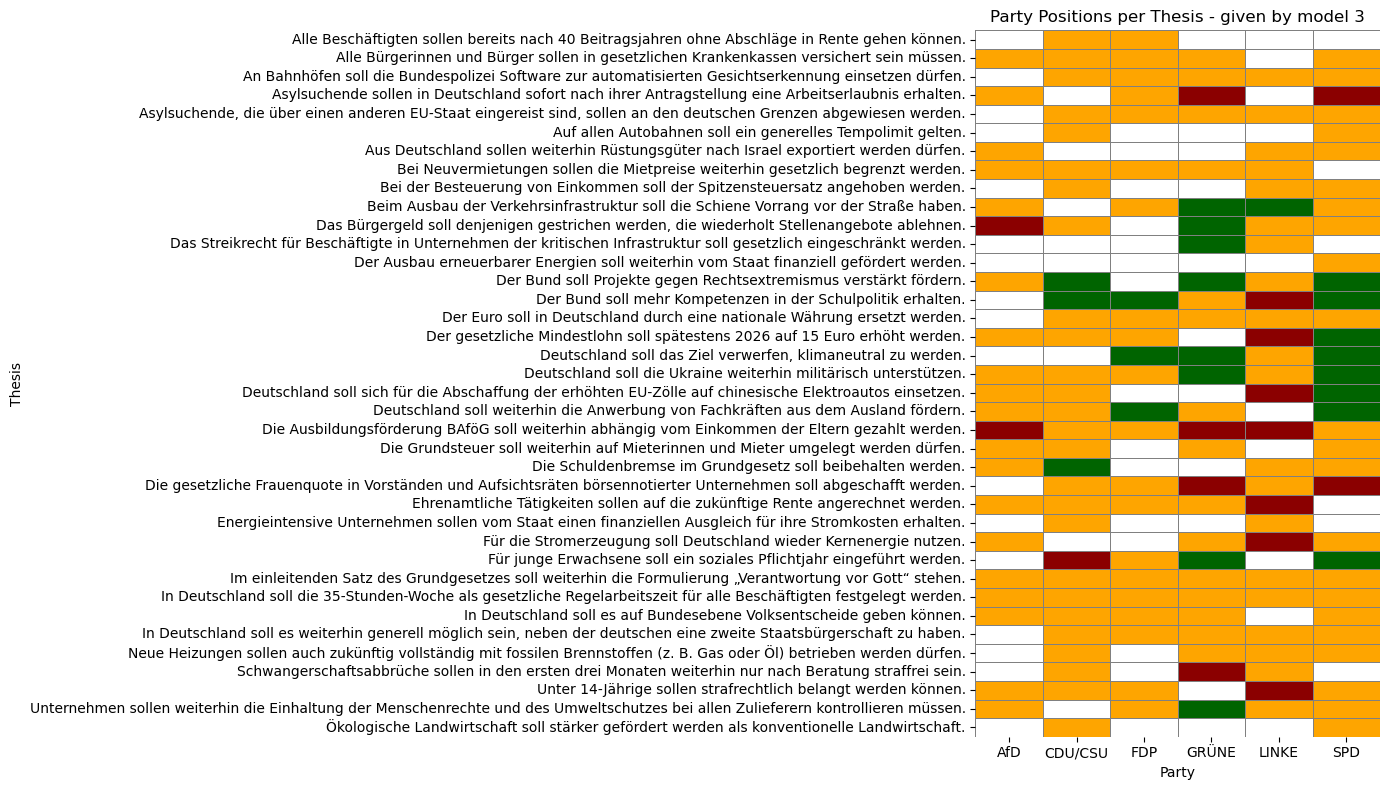

In [123]:
visualize("model_3_cat")

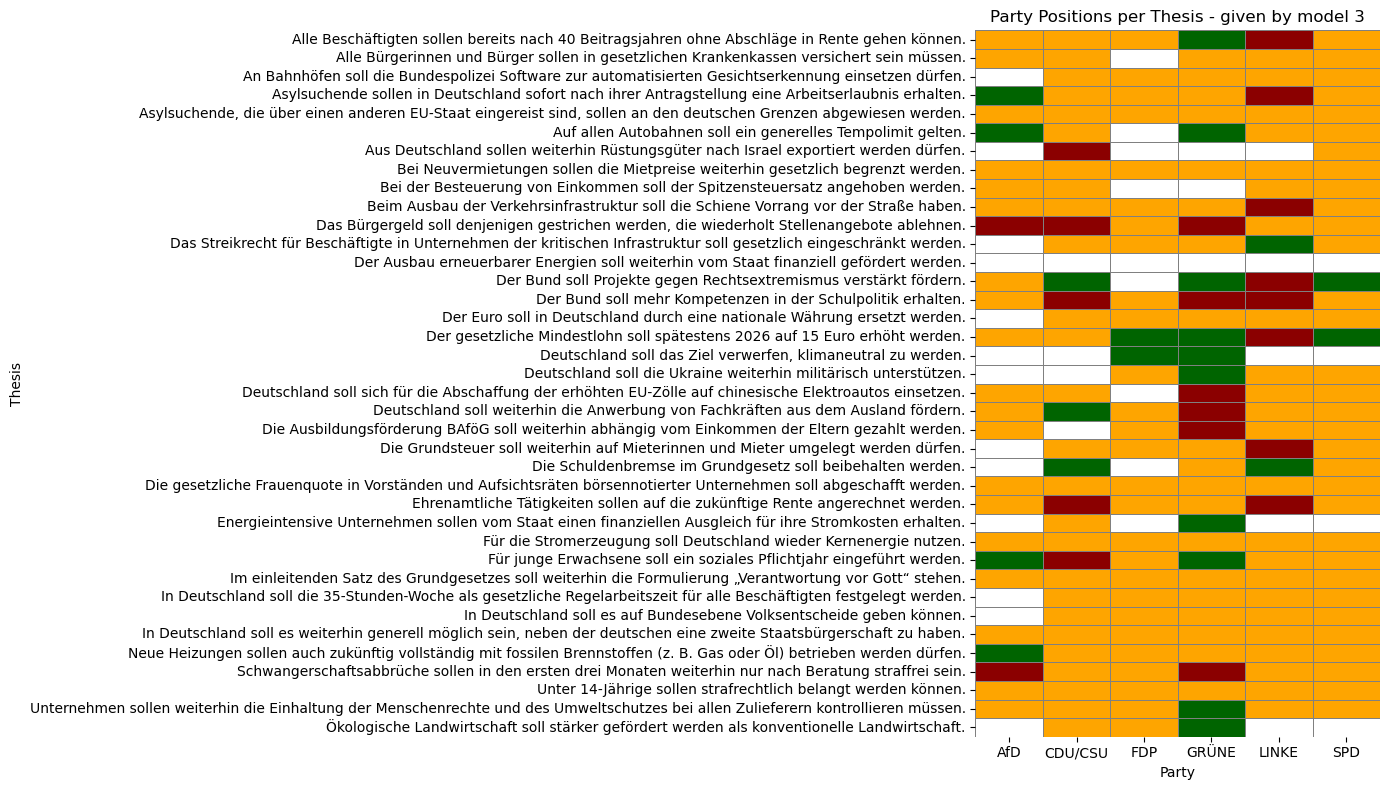

In [124]:
visualize("model_1_cat")

_______________________________________________________________________________
Compare real answers with model answers
________________________________________________________________________________

In [125]:
# define function to display eval metrics
def get_metrics(true_labels, preds, model_name):
    metrics_summary = {}

    acc = accuracy_score(true_labels, preds)
    bal_acc = balanced_accuracy_score(true_labels, preds)

    precision = precision_score(true_labels, preds, average='macro', zero_division=0)
    recall = recall_score(true_labels, preds, average='macro', zero_division=0)
    f1 = f1_score(true_labels, preds, average='macro', zero_division=0)

    label_order = sorted(set(true_labels).union(set(preds)))
    report = classification_report(true_labels, preds, labels=label_order, zero_division=0)
    metrics_summary[model_name] = {
        'acc': acc,
        'bal_acc': bal_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    # print metrics
    print(f"Model: {model_name}")
    print(f"  Accuracy: {acc}")
    print(f"  Balanced Accuracy: {bal_acc}")
    print(f"  Precision: {precision}")
    print(f"  Recall: {recall}")
    print(f"  F1-score: {f1}")
    print(f"  Classification Report:\n{report}")


    # Confusion Matrix
    label_order = sorted(set(true_labels).union(set(preds)))
    cm = confusion_matrix(true_labels, preds, labels=label_order)
    cm_df = pd.DataFrame(cm, index=label_order, columns=label_order)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Reds')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()


    return metrics_summary



/Users/ellaalle/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Model: Model_1
  Accuracy: 0.14035087719298245
  Balanced Accuracy: 0.3159389314003233
  Precision: 0.2248007600896225
  Recall: 0.23695419855024247
  F1-score: 0.11284421715184893
  Classification Report:
                 precision    recall  f1-score   support

           None       0.00      0.00      0.00         0
        neutral       0.10      0.78      0.17        18
stimme nicht zu       0.24      0.05      0.08       103
      stimme zu       0.57      0.12      0.20       107

       accuracy                           0.14       228
      macro avg       0.22      0.24      0.11       228
   weighted avg       0.38      0.14      0.14       228



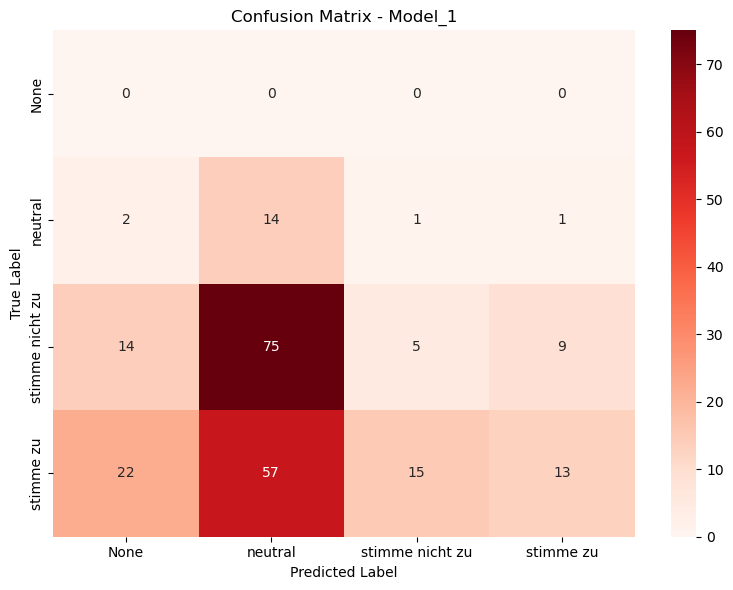

In [126]:
model_1 = get_metrics(wahlomat_data["answer"], wahlomat_data["model_1_cat"], "Model_1")

/Users/ellaalle/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Model: Model_3
  Accuracy: 0.14035087719298245
  Balanced Accuracy: 0.2852534051154866
  Precision: 0.2705140769779045
  Recall: 0.21394005383661494
  F1-score: 0.12191338073691013
  Classification Report:
                 precision    recall  f1-score   support

           None       0.00      0.00      0.00         0
        neutral       0.10      0.67      0.17        18
stimme nicht zu       0.38      0.06      0.10       103
      stimme zu       0.61      0.13      0.22       107

       accuracy                           0.14       228
      macro avg       0.27      0.21      0.12       228
   weighted avg       0.46      0.14      0.16       228



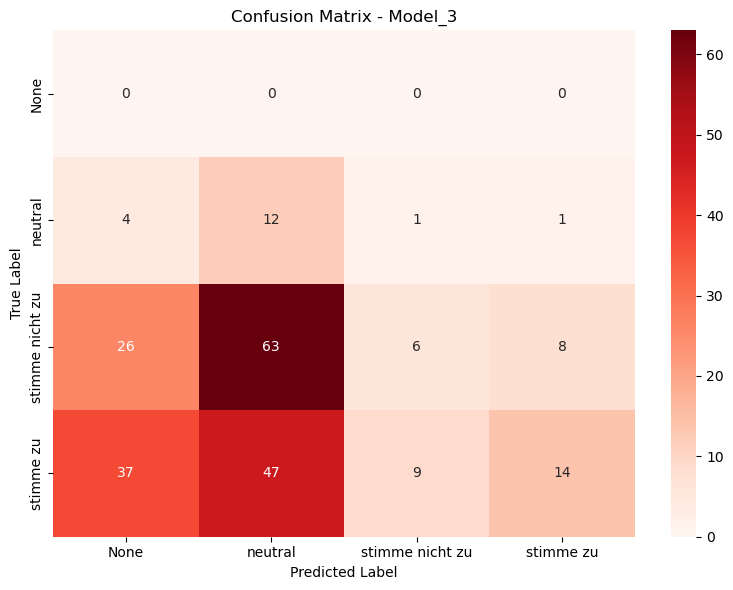

In [127]:
model_3 = get_metrics(wahlomat_data["answer"], wahlomat_data["model_3_cat"], "Model_3")

In [128]:
# merge dictionaries
combined_results = {**model_1, **model_3}

# Convert to DataFrame
df = pd.DataFrame.from_dict(combined_results, orient='index')
df

,acc,bal_acc,precision,recall,f1
Model_1,0.140351,0.315939,0.224801,0.236954,0.112844
Model_3,0.140351,0.285253,0.270514,0.213940,0.121913
